# Modelando el número de personas infectadas por SARS-COV-2

*Disclaimer*

Este es un ejercicio con fines didácticos, con modelos extremadamente simplificados, por lo que no pueden ser utilizados como referente en la toma de decisiones.

*Nota*

La organización de Our World in Data dejó de publicar nuevos datos a partir del 18 de marzo por encontrar [inconsistencias](https://ourworldindata.org/covid-sources-comparison) en la fuente de su información. La organización recomienda la [ECDC](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) o los datos del [CSSE](https://coronavirus.jhu.edu/map.html) de la Universidad de John Hopkins.

In [18]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Datos
df_original = pd.read_csv("https://covid.ourworldindata.org/data/total_cases.csv")

# Selección de casos
pais = "Spain"

## Definición de modelos

Se usan dos tipos de funciones: la logística y la exponencial.

La logística se define como

$$
f(x, a, b, c) = \frac{c}{1 + e^{\frac{-(x - b)}{a}}}
$$

en donde $x$ son los días, $a$ la velocidad de infección, $b$ el día con el máximo número de casos confirmados (que es el punto de inflexión donde después la tasa de infección comienza a decrecer) y $c$ el número total de personas infectadas al final del ciclo de infección.

Por otro lado, la función exponencial se define como:

$$f(x, a, b, c) = a \cdot e^{b(x -c)}  $$

con los mismos parámetros que la logística.

En Python se escribe de la siguiente manera:

In [19]:
def modelo_logistico(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

def modelo_exponencial(x, a, b, c):
    return a * np.exp( b * (x - c))

## Modelo logístico

Se selecciona el país puesto en `country` y se crea una columna `days`que indica los días que han transcurrido desde el 1 de enero. Luego se crean `x` e `y` como listas de las columnas `days` y los casos del país, respectivamente.

In [36]:
df = df_original
df = df[['date', country]]
df = df[True != df[country].isna()]

FMT = '%Y-%m-%d'
primer_dia = datetime.strptime(df.iloc[0,0], FMT)

df = df.assign(days = df['date'].map(lambda x : (datetime.strptime(x, FMT) - primer_dia).days))
x = list(df.iloc[:, 2])
y = list(df.iloc[:, 1])

In [37]:
df.tail()

,date,Spain,days
52,2020-03-13,2965.0,41
53,2020-03-14,4231.0,42
54,2020-03-15,5753.0,43
55,2020-03-16,7753.0,44
56,2020-03-17,9191.0,45


Luego se utiliza la función creada de `modelo_logistico` con `curve_fit`, que calcula los parámetros del modelo y también genera una matriz de covarianzas

Los objetos `p0_*` son valores iniciales hipotéticos para el ajuste de funciones. Se usan dentro del argumento `p0` y en el modelo logístico equivale a:

$$
\frac{40000}{1 + e^{\frac{-(x - 20)}{5}}}
$$

In [33]:
p0_log = [5, 20, 40000]

ajuste = curve_fit(modelo_logistico, xdata=x, ydata=y, p0=p0_log, maxfev=2000)
a, b, c = ajuste[0]
errores = np.sqrt(np.diag(ajuste[1]))

Los resultados del modelo se muestran con sus errores estándar:

In [38]:
for l, p, e in zip(["a: ", "b: ", "c: "], ajuste[0], errores):
    print(l, str(round(p, 3)), '+/-' , str(round(e, 4)))

a:  2.376 +/- 0.0547
b:  44.605 +/- 0.2225
c:  17189.697 +/- 826.4322


Con estos parámetros podemos saber que:

In [35]:
print("Número esperado de infectados al final del modelo:", int(c), 'con un error de', int(errores[2]))
print("Fecha del punto de inflexión: ", datetime.strftime(primer_dia + timedelta(days=b), FMT))

Número esperado de infectados al final del modelo: 17189 con un error de 826
Fecha del punto de inflexión:  2020-03-16


Para calcular el último día de la infección, según el modelo, se utiliza la función `fsolve` para obtener la raíz de la función logística, del cual se vería de la siguiente forma:

$$
\frac{17189.69}{1 + e^{-(75.60 - 75.60)/2.37}} - 17189.69 = \frac{17189.69}{1 + e^{0}} - 17189.69
$$

In [39]:
solucion = int(fsolve(lambda z : modelo_logistico(z, a, b, c) - int(c), b))
ultimo_dia = datetime.strftime(primer_dia + timedelta(days=solucion), FMT)
print("Último día de infecciones : ", ultimo_dia , " (aproximadamente)")

Último día de infecciones :  2020-04-09  (aproximadamente)


## Modelo exponencial

Ahora hacemos el mismo procedimiento con la función logística. Hay que tomar en cuenta que en este modelo no existe un fin, i.e. el número de infectados crecerá al infinito. Para dar un número más o menos "realista", utilizamos como fin el último día que da el modelo logístico.

In [42]:
p0_exp = [1, 1, 1]
ajuste_exp = curve_fit(modelo_exponencial, x, y, p0=p0_exp)
pred_x = list(range(max(x), solucion))

for l, p, e in zip(["a: ", "b: ", "c: "], ajuste_exp[0], errores):
    print(l, str(round(p, 3)), '+/-' , str(round(e, 4)))

a:  0.023 +/- 0.0547
b:  0.294 +/- 0.2225
c:  0.825 +/- 826.4322


Gráficamente, se ve la siguiente manera:

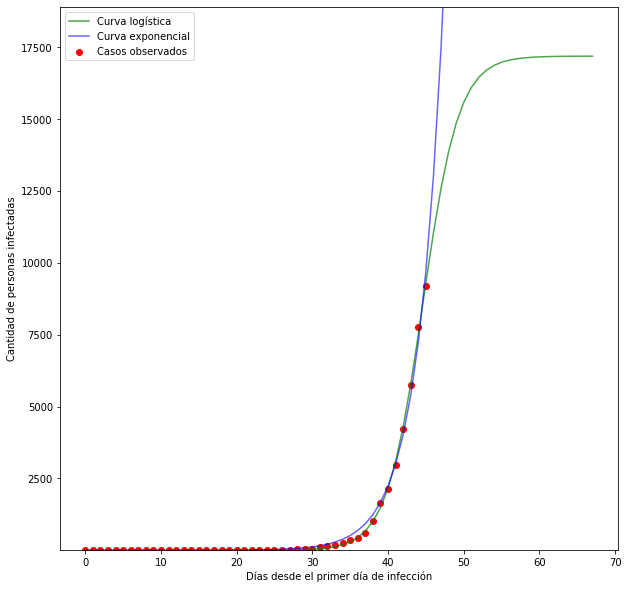

In [43]:
fig = plt.figure(figsize = (10, 10))
plt.scatter(df.iloc[:, 2], df.iloc[:, 1], label='Casos observados', color = "red")
plt.plot(x+pred_x, [modelo_logistico(i,ajuste[0][0],ajuste[0][1],ajuste[0][2]) for i in x+pred_x], label="Curva logística", alpha=0.7, color = "green")
plt.plot(x+pred_x, [modelo_exponencial(i,ajuste_exp[0][0],ajuste_exp[0][1],ajuste_exp[0][2]) for i in x+pred_x], label="Curva exponencial",alpha=0.6, color = "blue")
plt.legend()
plt.xlabel("Días desde el primer día de infección")
plt.ylabel("Cantidad de personas infectadas")
plt.ylim((min(y) * 0.9 , c * 1.1))
plt.show()